# Message passing for epidemiological interventions on networks with loops


This notebook demonstrates the implementation of Neighborhood Message Passing (NMP) for evaluating network interventions, as described in "Message passing for epidemiological interventions on networks with loops." ([Weis et al., 2025](http://arxiv.org/abs/2502.xxxxx)). 
NMP is a method for efficiently calculating the probability of infection for nodes in a network during cascade dynamics, such as disease spread or information diffusion---see ([Cantwell and Newman, 2019](https://doi.org/10.1073/pnas.1914893116)) for details.

The notebook shows to use NMP to evaluate three types of network interventions: influence maximization (finding optimal seed nodes), vaccination strategies (identifying critical nodes to immunize), and sentinel surveillance (placing monitors to detect outbreaks early). 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.neighborhood_message_passing import NeighborhoodMessagePassing

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=12)

## Problem specification

Our implementation works directly with networkx graphs. 

Within NMP, a calculation is defined by a network structure `g`, an infection probability `p`, a neighborhood depth `r`, a maximal simulation length `t_max`, and a number of Monte Carlo samples `M`.

In [3]:
g = nx.karate_club_graph()
r = 1
p = 0.2
t_max = 50
M = 10

In what follows, we'll illustrate all interventions by intervening on nodes 0 and 10, visualized below

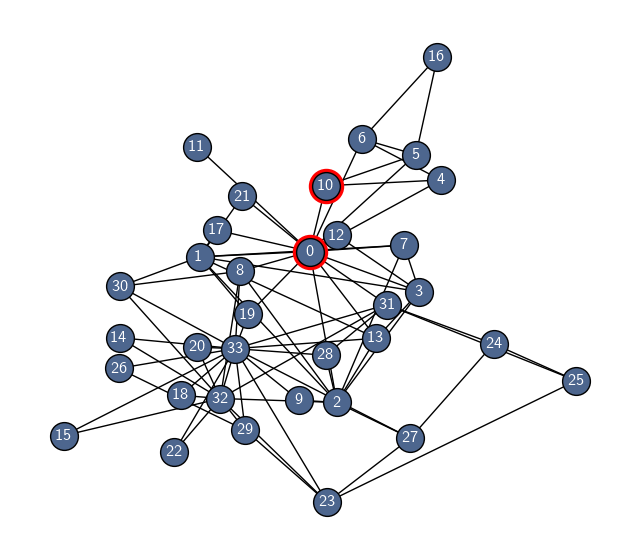

In [4]:
pos = nx.kamada_kawai_layout(g)
plt.figure(figsize=(8, 7))
nx.draw_networkx_nodes(g, pos=pos, nodelist=[0, 10], node_color='r', edgecolors='r', node_size=600)
nx.draw(g, pos=pos, node_color='#4d668e', with_labels=True, edge_color='k', edgecolors='black', node_size=400, font_color='w')


## Influence maximization

For the influence maximization problem, our goal is maximize the number of infected nodes.

The snippet below calculates the expected outbreak size when a cascade is seeded at nodes 0 and 10.
It can be used within an optimization loop to find an optimal seed set.

In [5]:
n = len(g)
seeds = [0,10]

# set the seed `s` and the vaccinated nodes `v`
s = np.zeros(n)
s[seeds] = 1

# no vaccinated nodes
v = np.zeros(n)

# run simulation
NMP = NeighborhoodMessagePassing(g, r, p, t_max, 
                                    M=M, v = v, verbose=True, temporal = True)

NMP.neighborhood_message_passing(s)
marginals = NMP.marginals

Constructing neighborhoods for N_i excluding N_j.


100%|██████████| 34/34 [00:00<00:00, 20071.26it/s]


Sampling neighborhoods for marginal calculations.


100%|██████████| 34/34 [00:00<00:00, 17094.98it/s]


Sampling neighborhoods for N_i excluding N_j.


Message passing iterations:  55%|█████▌    | 27/49 [00:00<00:00, 500.32it/s]

Converged early after 27 iterations


`marginal` nows contains the marginal probability that each node is infected at time $t$. (We set the flag `temporal=True`  to indicate that we want accurate marginal probabilities at every time step. When `temporal=False`, the code uses a computational shortcut and only the final marginals are valid.) We can see that nodes 0 and 10 have an infection probability of 1, since they were part of the seed.

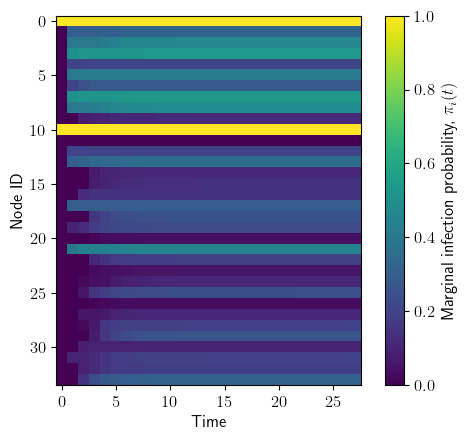

In [6]:
plt.imshow(marginals)
plt.xlabel('Time')
plt.ylabel('Node ID')
plt.colorbar(label=r'Marginal infection probability, $\pi_i(t)$')

We can extract various quantities of interest from this array, e.g., the expected outbreak size at every time step:

In [7]:
# extract the expected outbreak size
pi_t = np.sum(marginals, axis=0)
print("Influence maximization", pi_t)

Influence maximization [2.         6.3        7.166      8.20627176 8.77472196 9.144496
 9.33398342 9.43916236 9.50509776 9.54980814 9.5783481  9.59540518
 9.60561448 9.61192848 9.61591732 9.61843784 9.62000438 9.62097144
 9.62156903 9.62194115 9.62217335 9.62231811 9.62240817 9.62246414
 9.62249893 9.62252058 9.62253406 9.62254245]


Or we can plot individual trajectories for each nodes on a more standard chart:

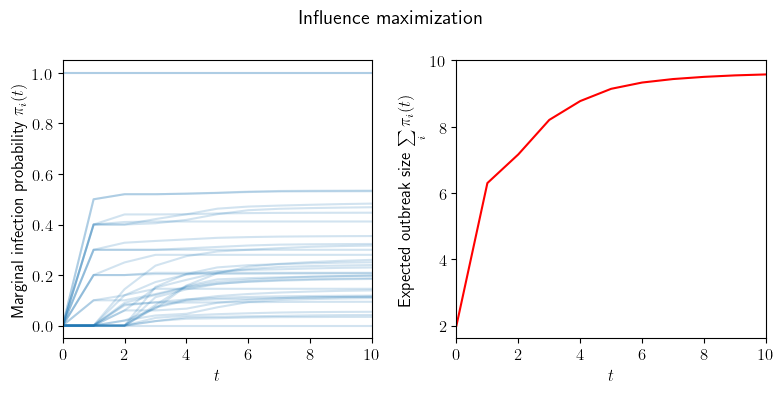

In [8]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
xlim = [0, 10]

ax = axes[0]
ax.plot(marginals.T,color = 'C0', alpha = 0.2)
ax.set(xlabel=r'$t$', ylabel= r'Marginal infection probability $\pi_i(t)$')
ax.set(xlim=xlim)

ax = axes[1]
ax.plot(pi_t, color = 'red')
ax.set(xlabel=r'$t$', ylabel= r'Expected outbreak size $\sum\limits_i \pi_i(t)$')
ax.set(xlim=xlim)

plt.suptitle("Influence maximization")
plt.tight_layout()

## Vaccination

Vaccination proceeds similarly. 
The goal is to *minimize* the expected number of infected nodes.

The snippet below calculates the outbreak size when nodes 0 and 10 are vaccinated and the outbreak starts at a random location. A node `i` is fully vaccinated when `v[i]=1` and fully susceptible when `v[i]=0`.

In [9]:
n = len(g)
vaccinated_nodes = [0,10]

# set the vaccinated nodes `v`
v = np.zeros(n)
for i in vaccinated_nodes:
    v[i] = 1

# set the seed `s`. each node is initially infected with probability 1/(n-|v|) where |v| is the number of vaccinated nodes and n is the number of nodes
s = np.zeros(n)
s += 1/(n-len(vaccinated_nodes))

# vaccinated nodes cannot be the seed
s[list(vaccinated_nodes)] = 0

# run NMP
NMP = NeighborhoodMessagePassing(g, r, p, t_max, M=M, v=v, temporal=True, verbose=False)
NMP.neighborhood_message_passing(s)
marginals = NMP.marginals

In [10]:
# extract the expected outbreak size
pi_t = np.sum(marginals, axis=0)
print("Vaccination",pi_t)

Vaccination [1.         1.85812066 2.61477523 2.99717126 3.22932494 3.3844015
 3.48005099 3.5397158  3.57661139 3.59945942 3.61322316 3.62161856
 3.62678421 3.62997393 3.63194321 3.6331547  3.63389877 3.63435598
 3.63463727 3.63481048 3.63491711 3.63498272 3.63502308 3.63504791
 3.63506319 3.63507259]


Again, `marginal` contains the marginal probability that each node is infected at time $t$.
In this case, we can see that node 0 and 10 are never infected, because they have been vaccinated.

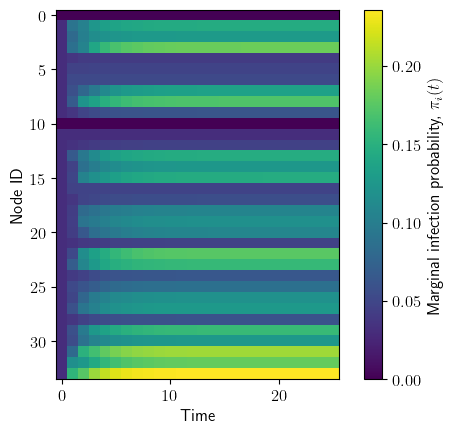

In [11]:
plt.imshow(marginals)
plt.xlabel('Time')
plt.ylabel('Node ID')
plt.colorbar(label=r'Marginal infection probability, $\pi_i(t)$')

Like before, we can also plot the evolution of the marginal on more conventional charts.

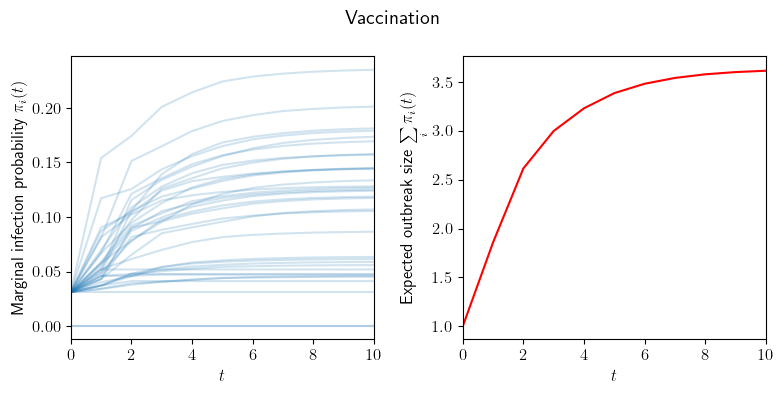

In [12]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
xlim = [0, 10]

ax = axes[0]
ax.plot(marginals.T,color = 'C0', alpha = 0.2)
ax.set(xlabel=r'$t$', ylabel= r'Marginal infection probability $\pi_i(t)$')
ax.set(xlim=xlim)

ax = axes[1]
ax.plot(pi_t, color = 'red')
ax.set(xlabel=r'$t$', ylabel= r'Expected outbreak size $\sum\limits_i \pi_i(t)$')
ax.set(xlim=xlim)

plt.suptitle("Vaccination")
plt.tight_layout()

## Sentinel Surveillance


For the sentinel surveillance problem, we instead need to calculate the time to *detection* of every node.

In [13]:
n = len(g)
sentinels = [0, 10]

# for the calculation to be well-defined, we need to "vaccinate" the sentinels --- we're instead in the time to detection  
# when the cascades does not go through another sentinel
v = np.zeros(n)
for i in sentinels:
    v[i] = 1

# we seed the cascade at random otherwise
s = np.zeros(n)
s += 1/n

NMP = NeighborhoodMessagePassing(g, r, p, t_max, M=M, v=v, verbose=True, temporal=True)
NMP.neighborhood_message_passing(s,track_vaccinated=True)
marginals = NMP.marginals

Constructing neighborhoods for N_i excluding N_j.


100%|██████████| 34/34 [00:00<00:00, 17719.48it/s]


Sampling neighborhoods for marginal calculations.


100%|██████████| 34/34 [00:00<00:00, 20670.58it/s]


Sampling neighborhoods for N_i excluding N_j.


Message passing iterations:  57%|█████▋    | 28/49 [00:00<00:00, 652.03it/s]

Converged early after 28 iterations


The quantity of interest is no longer the array of marginal probabilities, but the probability that the cascade arrives at one of the sentinels by time $t$. This can be calculated as the product:

In [14]:
marginals_S = marginals[sentinels,:]
prob_set_infected_by_t = 1 - np.prod(1 - marginals_S, axis=0)

We also argue that the following quantity is a good way to calculate the expected time to detection

In [15]:
D = nx.diameter(g)
pi = prob_set_infected_by_t[-1]
diff = np.diff(prob_set_infected_by_t)
time_to_detect = (1 - pi) * D + pi * np.sum(diff * np.arange(1, len(diff) + 1, 1))


We can see that both sentinels eventually detect the cascade with near certainty, but that node 10 takes longer to do so (since it is on the periphery of the network.)

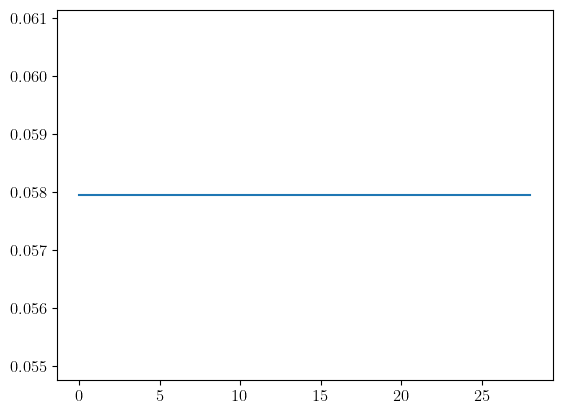

In [17]:
plt.plot(prob_set_infected_by_t)

Text(5.210207612456747, 0.2, 'Expected time to detection\n $t=4.71$')

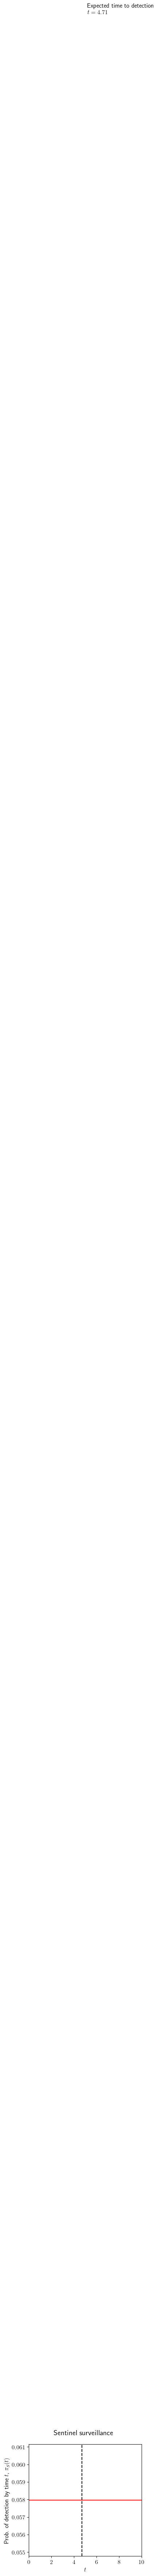

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.plot(prob_set_infected_by_t, color='red')
ax.set(xlabel=r'$t$', ylabel= r'Prob. of detection by time $t$, $\pi_S(t)$')
ax.set(xlim=[0, 10])
plt.suptitle("Sentinel surveillance")
plt.axvline(time_to_detect, color='black', linestyle='--')
plt.text(time_to_detect+0.5, 0.2, f'Expected time to detection\n $t={time_to_detect:.2f}$', rotation=0, verticalalignment='center')

# Temporal vs. Atemporal, Vaccination

In [18]:
r = 1

In [19]:
n = len(g)
vaccinated_nodes = [0,10]

# set the vaccinated nodes `v`
v = np.zeros(n)
for i in vaccinated_nodes:
    v[i] = 1

# set the seed `s`. each node is initially infected with probability 1/(n-|v|) where |v| is the number of vaccinated nodes and n is the number of nodes
s = np.zeros(n)
s += 1/(n-len(vaccinated_nodes))

# vaccinated nodes cannot be the seed
s[list(vaccinated_nodes)] = 0

# run NMP
NMPt = NeighborhoodMessagePassing(g, r, p, 50, M=500, v=v, temporal=True, verbose=False)
NMPt.neighborhood_message_passing(s)
marginals = NMPt.marginals

In [20]:
n = len(g)
vaccinated_nodes = [0,10]

# set the vaccinated nodes `v`
v = np.zeros(n)
for i in vaccinated_nodes:
    v[i] = 1

# set the seed `s`. each node is initially infected with probability 1/(n-|v|) where |v| is the number of vaccinated nodes and n is the number of nodes
s = np.zeros(n)
s += 1/(n-len(vaccinated_nodes))

# vaccinated nodes cannot be the seed
s[list(vaccinated_nodes)] = 0

# run NMP
NMP = NeighborhoodMessagePassing(g, r, p,50, M=30, v=v, temporal=False, verbose=False)
NMP.neighborhood_message_passing(s)
marginals_atemporal = NMP.marginals

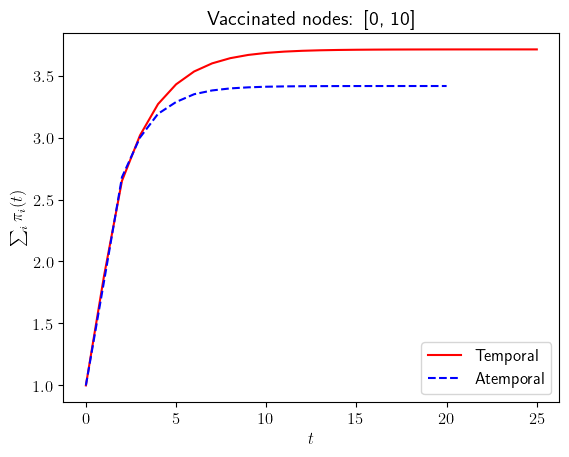

In [22]:
# extract the expected outbreak size
pi_t = np.sum(marginals, axis=0)
pi_t_atemporal = np.sum(marginals_atemporal, axis=0)

plt.plot(pi_t, label='Temporal', color='red')
plt.plot(pi_t_atemporal, label='Atemporal', color='blue', linestyle='--')
#plt.plot(pi_t - pi_t_atemporal, label='Temporal - Atemporal', color='green', linestyle='--')
plt.title('Vaccinated nodes: [0, 10]')
plt.xlabel('$t$')
plt.ylabel(r'$\sum_i \pi_i(t)$')
plt.legend()

In [23]:
NMP.state[1].keys()

dict_keys([0, 2, 3, 7, 13, 17, 19, 21, 30])

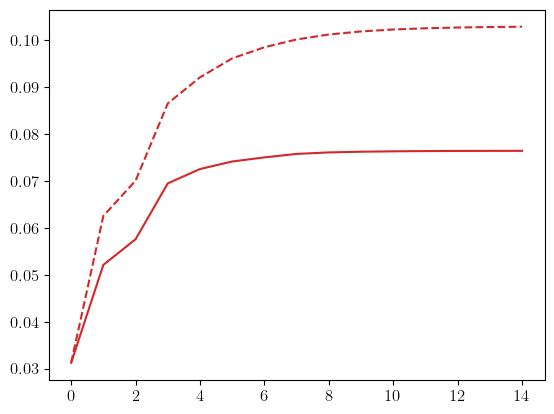

In [24]:
t_max = 15
for idx,j in enumerate(NMP.state[1].keys()):
    if j != 7:
        continue
    plt.plot(NMP.state[1][j][:t_max], label=f'Node {j}',color = f'C{idx}')
    plt.plot(NMPt.state[1][j][:t_max], label=f'Node {j}', linestyle='--',color = f'C{idx}')

In [25]:
NMP.neighborhoods_i_except_j[1][7]

Neighborhood(
    i=1,
    nodes=[0, 1, 2, 3, 13, 17, 19, 21, 30],
    edges=[(0, 13), (0, 17), (0, 19), (0, 21), (2, 13), (3, 13)],
    neighbors_i=[13, 17, 19, 21, 30],
    Gamma_samples=[GammaSample(
    clusters=[[2, 13], [17], [19], [21], [30]], 
    num_neighbors=[1, 1, 1, 1, 1],
    prob=0.18133333333333332), GammaSample(
    clusters=[[2, 3, 13], [17], [19], [21], [30]], 
    num_neighbors=[1, 1, 1, 1, 1],
    prob=0.04000000000000003), GammaSample(
    clusters=[[3, 13], [17], [19], [21], [30]], 
    num_neighbors=[1, 1, 1, 1, 1],
    prob=0.1386666666666666), GammaSample(
    clusters=[[13], [17], [19], [21], [30]], 
    num_neighbors=[1, 1, 1, 1, 1],
    prob=0.2621440000000001)]
)

In [26]:
NMPt.neighborhoods_i_except_j[1][7]

Neighborhood(
    i=1,
    nodes=[0, 1, 2, 3, 13, 17, 19, 21, 30],
    edges=[(1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (0, 13), (0, 17), (0, 19), (0, 21), (2, 13), (3, 13)],
    neighbors_i=[13, 17, 19, 21, 30],
    Gamma_samples=[TemporalGammaSample(reachable_nodes=[], distances=[]), TemporalGammaSample(reachable_nodes=[13, 30, 2], distances=[1, 1, 2]), TemporalGammaSample(reachable_nodes=[13, 17], distances=[1, 1]), TemporalGammaSample(reachable_nodes=[17, 21], distances=[1, 1]), TemporalGammaSample(reachable_nodes=[21], distances=[1]), TemporalGammaSample(reachable_nodes=[30], distances=[1]), TemporalGammaSample(reachable_nodes=[17, 19], distances=[1, 1]), TemporalGammaSample(reachable_nodes=[21, 30], distances=[1, 1]), TemporalGammaSample(reachable_nodes=[13, 21, 2], distances=[1, 1, 2]), TemporalGammaSample(reachable_nodes=[17], distances=[1]), TemporalGammaSample(reachable_nodes=[17, 30], distances=[1, 1]), TemporalGammaSample(reachable_nodes=[13, 19], distances=[1, 1]), Temp

In [27]:
samples = NMP.neighborhoods_i_except_j[1][7].Gamma_samples
probs = [samp.prob for samp in samples]
print(sum(probs))
#assert np.isclose(sum(probs),1)

0.622144


In [28]:
samples = NMPt.neighborhoods_i_except_j[1][7].Gamma_samples
samples_nz = [samp for samp in samples if samp.reachable_nodes != []]
print(sum(x.prob for x in samples_nz))
#assert np.isclose(sum(probs),1)

0.6660000000000003


In [29]:
samples = NMPt.neighborhoods_i_except_j[1][7].Gamma_samples
probs = [samp.prob for samp in samples]
print(sum(probs))
assert np.isclose(sum(probs),1)

1.0000000000000004


In [30]:
samples = NMP.neighborhoods_i_except_j[1][7].Gamma_samples
from collections import defaultdict
j2reachable_prob = defaultdict(float)
f = lambda x,list_of_lists: any(x in l for l in list_of_lists)
for k in NMP.neighborhoods_i_except_j[1][7].nodes:
    j2reachable_prob[k] = sum(samp.prob for samp in samples if f(k,samp.reachable_nodes))
print(j2reachable_prob)

defaultdict(<class 'float'>, {0: 0, 1: 0, 2: np.float64(0.22133333333333335), 3: np.float64(0.17866666666666664), 13: np.float64(0.622144), 17: np.float64(0.622144), 19: np.float64(0.622144), 21: np.float64(0.622144), 30: np.float64(0.622144)})


In [31]:
samples = NMPt.neighborhoods_i_except_j[1][7].Gamma_samples
from collections import defaultdict
j2reachable_prob_t = defaultdict(float)
f = lambda x,list_of_lists: any(x in l for l in list_of_lists)
for k in NMP.neighborhoods_i_except_j[1][7].nodes:
    j2reachable_prob_t[k] = sum(samp.prob for samp in samples if k in samp.reachable_nodes)
print(j2reachable_prob_t)

defaultdict(<class 'float'>, {0: 0, 1: 0, 2: 0.042, 3: 0.04000000000000001, 13: 0.19400000000000003, 17: 0.18800000000000008, 19: 0.19200000000000006, 21: 0.15600000000000003, 30: 0.2380000000000001})


In [32]:
for k in j2reachable_prob.keys():
    print(k, j2reachable_prob[k], j2reachable_prob_t[k])

0 0 0
1 0 0
2 0.22133333333333335 0.042
3 0.17866666666666664 0.04000000000000001
13 0.622144 0.19400000000000003
17 0.622144 0.18800000000000008
19 0.622144 0.19200000000000006
21 0.622144 0.15600000000000003
30 0.622144 0.2380000000000001


In [33]:
for k in j2reachable_prob.keys():
    print(k, j2reachable_prob[k], j2reachable_prob_t[k])

0 0 0
1 0 0
2 0.22133333333333335 0.042
3 0.17866666666666664 0.04000000000000001
13 0.622144 0.19400000000000003
17 0.622144 0.18800000000000008
19 0.622144 0.19200000000000006
21 0.622144 0.15600000000000003
30 0.622144 0.2380000000000001


## Sentinels

In [34]:
n = len(g)
sentinels = [0, 10]

# for the calculation to be well-defined, we need to "vaccinate" the sentinels --- we're instead in the time to detection  
# when the cascades does not go through another sentinel
v = np.zeros(n)
for i in sentinels:
    v[i] = 1

# we seed the cascade at random otherwise
s = np.zeros(n)
s += 1/n

NMP = NeighborhoodMessagePassing(g, r, p, t_max, M=M, v=v, verbose=True, temporal=True)
NMP.neighborhood_message_passing(s,track_vaccinated=True)
marginals = NMP.marginals

Constructing neighborhoods for N_i excluding N_j.


100%|██████████| 34/34 [00:00<00:00, 20592.97it/s]


Sampling neighborhoods for marginal calculations.


100%|██████████| 34/34 [00:00<00:00, 21493.04it/s]


Sampling neighborhoods for N_i excluding N_j.


Message passing iterations: 100%|██████████| 14/14 [00:00<00:00, 626.12it/s]


RuntimeError: Message passing did not converge in 15 time steps.

In [35]:
n = len(g)
sentinels = [0, 10]

# for the calculation to be well-defined, we need to "vaccinate" the sentinels --- we're instead in the time to detection  
# when the cascades does not go through another sentinel
v = np.zeros(n)
for i in sentinels:
    v[i] = 1

# we seed the cascade at random otherwise
s = np.zeros(n)
s += 1/n

NMP = NeighborhoodMessagePassing(g, r, p, t_max, M=M, v=v, verbose=True, temporal=False)
NMP.neighborhood_message_passing(s,track_vaccinated=True)
marginals_atemporal = NMP.marginals

Constructing neighborhoods for N_i excluding N_j.


100%|██████████| 34/34 [00:00<00:00, 22927.06it/s]


Sampling neighborhoods for marginal calculations.


100%|██████████| 34/34 [00:00<00:00, 678.07it/s]


Sampling neighborhoods for N_i excluding N_j.


Message passing iterations: 100%|██████████| 14/14 [00:00<00:00, 14.63it/s]


RuntimeError: Message passing did not converge in 15 time steps.

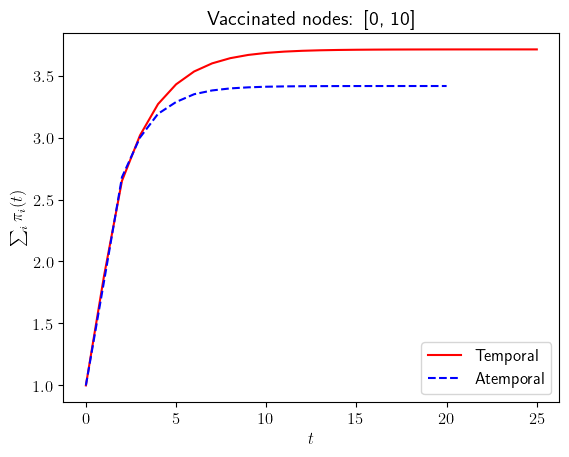

In [36]:
# extract the expected outbreak size
pi_t = np.sum(marginals, axis=0)
pi_t_atemporal = np.sum(marginals_atemporal, axis=0)

plt.plot(pi_t, label='Temporal', color='red')
plt.plot(pi_t_atemporal, label='Atemporal', color='blue', linestyle='--')
#plt.plot(pi_t - pi_t_atemporal, label='Temporal - Atemporal', color='green', linestyle='--')
plt.title('Vaccinated nodes: [0, 10]')
plt.xlabel('$t$')
plt.ylabel(r'$\sum_i \pi_i(t)$')
plt.legend()

# Influence max

In [91]:
n = len(g)
seeds = [0,10]

# set the seed `s` and the vaccinated nodes `v`
s = np.zeros(n)
s[seeds] = 1

# no vaccinated nodes
v = np.zeros(n)

# run simulation
NMP = NeighborhoodMessagePassing(g, r, p, 50, 
                                    M=M, v = v, verbose=True, temporal = True)

NMP.neighborhood_message_passing(s)
marginals = NMP.marginals

Constructing neighborhoods for N_i excluding N_j.


100%|██████████| 34/34 [00:00<00:00, 21467.16it/s]


Sampling neighborhoods for marginal calculations.


100%|██████████| 34/34 [00:00<00:00, 21076.90it/s]


Sampling neighborhoods for N_i excluding N_j.


Message passing iterations:  49%|████▉     | 24/49 [00:00<00:00, 510.67it/s]

Converged early after 24 iterations


In [92]:
n = len(g)
seeds = [0,10]

# set the seed `s` and the vaccinated nodes `v`
s = np.zeros(n)
s[seeds] = 1

# no vaccinated nodes
v = np.zeros(n)

# run simulation
NMP = NeighborhoodMessagePassing(g, r, p, 50, 
                                    M=M, v = v, verbose=True, temporal = False)

NMP.neighborhood_message_passing(s)
marginals_atemporal = NMP.marginals

Constructing neighborhoods for N_i excluding N_j.


100%|██████████| 34/34 [00:00<00:00, 7592.31it/s]


Sampling neighborhoods for marginal calculations.


100%|██████████| 34/34 [00:00<00:00, 407.46it/s]


Sampling neighborhoods for N_i excluding N_j.


Message passing iterations:  39%|███▉      | 19/49 [00:01<00:02, 12.35it/s]


Converged early after 19 iterations


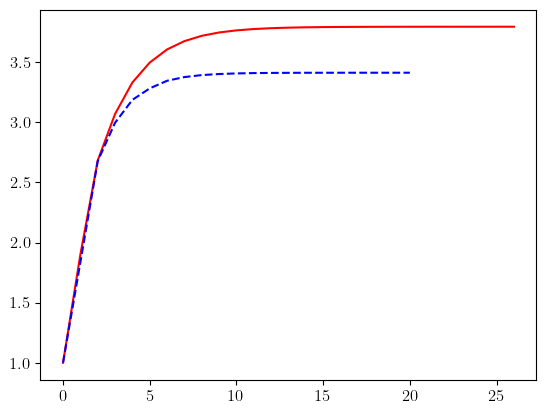

In [93]:
plt.plot(pi_t, label='Temporal', color='red')
plt.plot(pi_t_atemporal, label='Atemporal', color='blue', linestyle='--')
